In [1]:
import pandas as pd, numpy as np
import sys; sys.path.insert(0, '/Users/erezcohen/larlite/UserDev/mySoftware/MySoftwarePackage/mac/'); 
from my_tools import *
from plot_tools import *
%matplotlib inline

In [2]:
from ROOT import TEfficiency

In [49]:
k=TEfficiency()
k.SetStatisticOption(TEfficiency.kFFC)

def get_FeldmanCousinsEfficieny( passing=0, tot=1 , debug=0 ):
    if debug:
        print "passing:",passing
        print "tot:",tot

    # get efficiency +/- 1 sigma interval from Feldman Cousincs statistics
    eff       = passing/float(tot)
    eff_upper = k.FeldmanCousins(tot,passing,0.6827,True)
    eff_lower = k.FeldmanCousins(tot,passing,0.6827,False)
    
    if debug:
        print 'Efficiency : %.03f.'%(eff)
        print '1-sigma interval : [%.03f, %.03f]'%(eff_lower,eff_upper)
        
    return eff,(eff-eff_lower),(eff_upper-eff)

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: h_passed (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: h_total (Potential memory leak).


# What happens for a standard (default) GENIE sample?

In [6]:
# events = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/from_interactive/prodgenie_bnb_nu_cosmic_uboone_mcc8.7_reco2_dev_events.csv')
events = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/events/prodgenie_bnb_nu_cosmic_uboone_mcc8.7_reco2_dev_2018_03_23_events.csv')

In [50]:
MC_MC_Overlay=dict({'all':events
                ,'in TPC':events[(( (events['x(v-interaction)']>0)&(events['x(v-interaction)']<256)
                           &(events['y(v-interaction)']>-116)&(events['y(v-interaction)']<116)
                           &(events['z(v-interaction)']>0)&(events['z(v-interaction)']<1037))==True)]
                ,'outside TPC':events[(( (events['x(v-interaction)']>0)&(events['x(v-interaction)']<256)
                           &(events['y(v-interaction)']>-116)&(events['y(v-interaction)']<116)
                           &(events['z(v-interaction)']>0)&(events['z(v-interaction)']<1037))==False)]
                ,'contained in XY':events[(((events['y(v-interaction)']>-116)&(events['y(v-interaction)']<116)
                                            &(events['x(v-interaction)']>0)&(events['x(v-interaction)']<256))==True)]
                ,'contained in XZ':events[(((events['x(v-interaction)']>0)&(events['x(v-interaction)']<256)
                                            &(events['z(v-interaction)']>0)&(events['z(v-interaction)']<1037))==True)]
                ,'contained in YZ':events[(((events['y(v-interaction)']>-116)&(events['y(v-interaction)']<116)
                                            &(events['z(v-interaction)']>0)&(events['z(v-interaction)']<1037))==True)]           
                       })

for key in MC_MC_Overlay.keys():
    sample = MC_MC_Overlay[key]
    events_passed_SwT = sample[sample['passed_SwT']==True]
    eff , eff_lower , eff_upper = get_FeldmanCousinsEfficieny( passing=len(events_passed_SwT), tot=len(sample))
    print key
    print len(sample),'events,',len(events_passed_SwT),'passed SwT (%.1f'%(100*eff),'+ %.1f'%(100*(eff_upper) ),'- %.1f'%(100*(eff_lower) ),'%)'

all
129300 events, 111510 passed SwT (86.2 + 0.6 - 0.6 %)
in TPC
57227 events, 56027 passed SwT (97.9 + 0.1 - 0.1 %)
contained in YZ
83571 events, 74966 passed SwT (89.7 + 0.8 - 0.1 %)
outside TPC
72073 events, 55483 passed SwT (77.0 + 1.0 - 1.0 %)
contained in XZ
85881 events, 79811 passed SwT (92.9 + 0.1 - 0.1 %)
contained in XY
66407 events, 63644 passed SwT (95.8 + 0.1 - 0.1 %)


In [68]:
def plot_passrate_1D(label='all'
                     ,direction= 'z',bins=np.linspace(-150,1250,31)
                     ,x_label=r'$z$ [cm]',TPClim=(0,1037)
                     ,debug=0):
    sample = MC_MC_Overlay[label]
    sample_passed_SwT = sample[sample['passed_SwT']==True]

    h = dict()
    fig=plt.figure(figsize=(12,10))
    ax = fig.add_subplot(2,1,1)
    for sample,slabel,color in zip([sample,sample_passed_SwT]
                                   ,[label,'passed SwT']
                                   ,['royalblue','tomato']):
        h[slabel],bins,_=plt.hist(sample[direction+'(v-interaction)'],bins=bins,color=color,histtype='step',linewidth=3);
        plt.plot([0,0],[0,0],linewidth=3,label=slabel,color=color)
    set_axes(ax,'','counts',do_add_legend=True,remove_ticks_x=True
             ,do_add_grid=True,xlim=(np.min(bins),np.max(bins)),legend_loc='lower center')
    plt.plot([TPClim,TPClim],ax.get_ylim(),'--',color='black')

    ax = fig.add_subplot(2,1,2)
    mid = 0.5*(bins[1:]+bins[:-1])
    h['eff'],h['eff lower'],h['eff upper'] = 0.0*h[label],0.0*h[label],0.0*h[label]
    
    for i in range(len(h[label])):
        eff,eff_upper,eff_lower = get_FeldmanCousinsEfficieny( passing=int(h['passed SwT'][i])
                                                                                       ,tot=np.max([int(h[label][i]),1])
                                                                                       ,debug=debug)
        h['eff'][i],h['eff lower'][i],h['eff upper'][i]=eff,eff_upper,eff_lower
    plt.errorbar(x=mid,xerr=0,y=100*h['eff'],yerr=[100*h['eff lower'],100*h['eff upper']]
                 ,fmt='o',capthick=2,capsize=2,ecolor='red')


    set_axes(ax,x_label,r'$N_{events}^{pass-SwT}/N_{events}$ [%]',do_add_grid=True,xlim=(np.min(bins),np.max(bins)),ylim=(0,101))
    plt.plot([TPClim,TPClim],ax.get_ylim(),'--',color='black')

    plt.tight_layout()

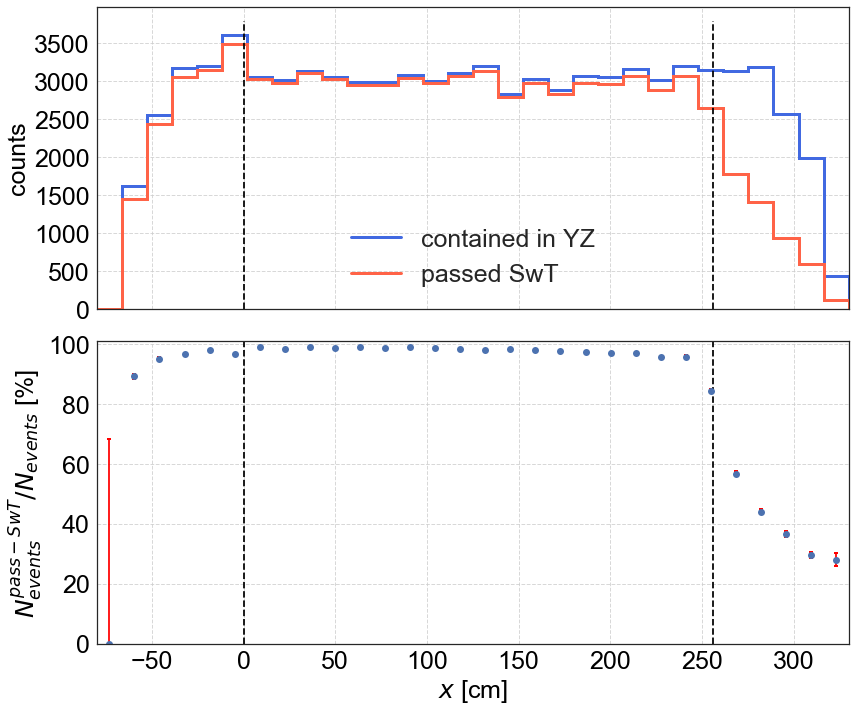

In [69]:
plot_passrate_1D(label='contained in YZ'
                     ,direction= 'x',bins=np.linspace(-80,330,31)
                     ,x_label=r'$x$ [cm]',TPClim=(0,256),debug=0)

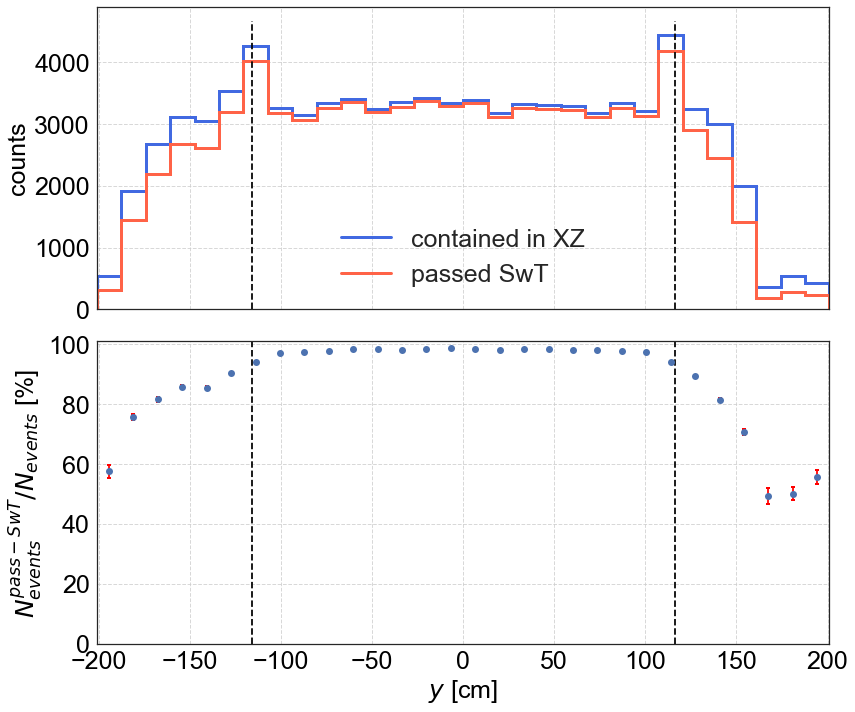

In [70]:
plot_passrate_1D(label='contained in XZ'
                     ,direction= 'y',bins=np.linspace(-201,201,31)
                     ,x_label=r'$y$ [cm]',TPClim=(-116,+116))

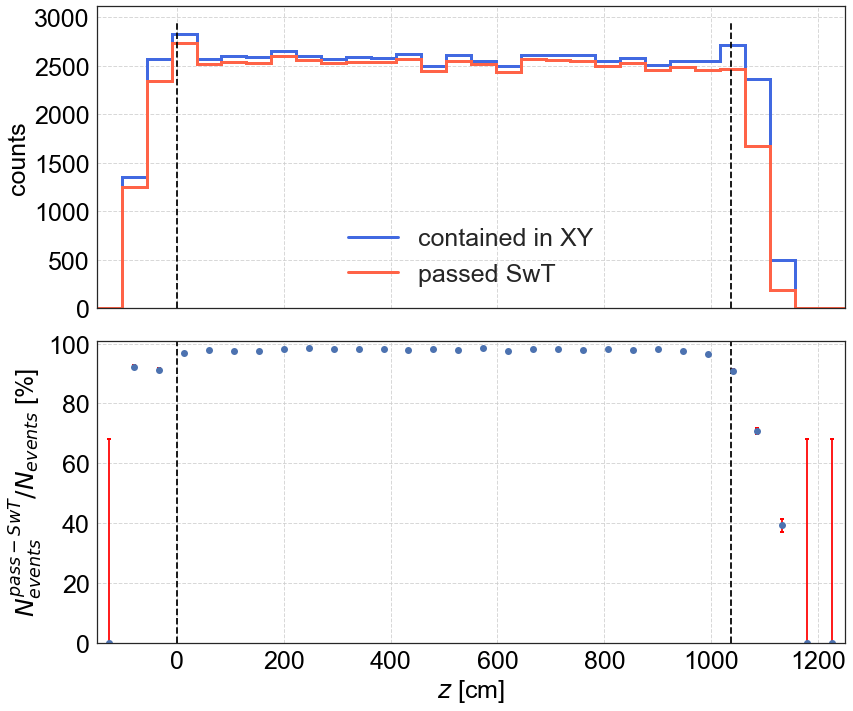

In [71]:
plot_passrate_1D(label='contained in XY'
                     ,direction= 'z',bins=np.linspace(-150,1250,31)
                     ,x_label=r'$z$ [cm]',TPClim=(0,1037))

# MC/DATA overlay

In [75]:
events = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/events/ecohen_physical_files_adi_prodgenie_bnb_nu_uboone_overlay_cosmic_data_100K_reco2_2018_03_24_events.csv')

In [76]:
MC_DATA_Overlay=dict({'all':events
                ,'in TPC':events[(( (events['x(v-interaction)']>0)&(events['x(v-interaction)']<256)
                           &(events['y(v-interaction)']>-116)&(events['y(v-interaction)']<116)
                           &(events['z(v-interaction)']>0)&(events['z(v-interaction)']<1037))==True)]
                ,'outside TPC':events[(( (events['x(v-interaction)']>0)&(events['x(v-interaction)']<256)
                           &(events['y(v-interaction)']>-116)&(events['y(v-interaction)']<116)
                           &(events['z(v-interaction)']>0)&(events['z(v-interaction)']<1037))==False)]
                ,'contained in XY':events[(((events['y(v-interaction)']>-116)&(events['y(v-interaction)']<116)
                                            &(events['x(v-interaction)']>0)&(events['x(v-interaction)']<256))==True)]
                ,'contained in XZ':events[(((events['x(v-interaction)']>0)&(events['x(v-interaction)']<256)
                                            &(events['z(v-interaction)']>0)&(events['z(v-interaction)']<1037))==True)]
                ,'contained in YZ':events[(((events['y(v-interaction)']>-116)&(events['y(v-interaction)']<116)
                                            &(events['z(v-interaction)']>0)&(events['z(v-interaction)']<1037))==True)]           
                       })

for key in MC_DATA_Overlay.keys():
    sample = MC_DATA_Overlay[key]
    events_passed_SwT = sample[sample['passed_SwT']==True]
    eff , eff_lower , eff_upper = get_FeldmanCousinsEfficieny( passing=len(events_passed_SwT), tot=len(sample))
    print key
    print len(sample),'events,',len(events_passed_SwT),'passed SwT (%.1f'%(100*eff),'+ %.1f'%(100*(eff_upper) ),'- %.1f'%(100*(eff_lower) ),'%)'

all
95595 events, 82875 passed SwT (86.7 + 0.8 - 0.8 %)
in TPC
42420 events, 41538 passed SwT (97.9 + 0.1 - 0.1 %)
contained in YZ
61558 events, 55444 passed SwT (90.1 + 0.1 - 0.1 %)
outside TPC
53175 events, 41337 passed SwT (77.7 + 1.4 - 1.4 %)
contained in XZ
63812 events, 59508 passed SwT (93.3 + 0.1 - 0.1 %)
contained in XY
49337 events, 47349 passed SwT (96.0 + 0.1 - 0.1 %)


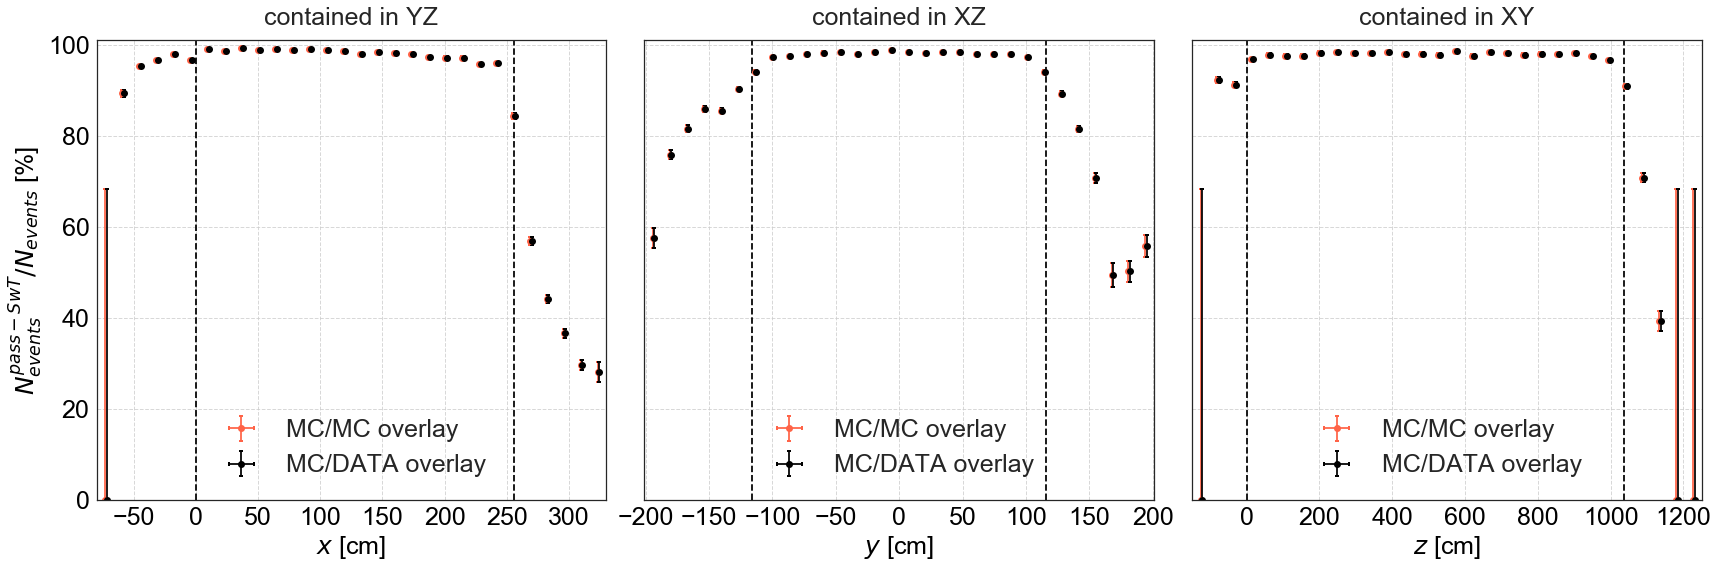

In [67]:
fig = plt.figure(figsize=(24,8))
for idir,(direction,bins,label,TPClim) in enumerate(zip(['x','y','z']
                                                        ,[np.linspace(-80,330,31),np.linspace(-201,201,31),np.linspace(-150,1250,31)]
                                                        ,['contained in YZ','contained in XZ','contained in XY']
                                                        ,[(0,256),(-116,116),(0,1037)])):
    x_label=r'$'+direction+'$ [cm]'
    h = dict()
    ax = fig.add_subplot(1,3,idir+1)
    for isample,(sample,slabel,color) in enumerate(zip([MC_MC_Overlay,MC_DATA_Overlay]
                                       ,['MC/MC overlay','MC/DATA overlay']
                                       ,['tomato','black'])):
        evnts = sample[label]
        h_evnts,bins = np.histogram(evnts[direction+'(v-interaction)'],bins=bins);
        evnts_passed_SwT = evnts[evnts['passed_SwT']==True]
        h_passed_SwT,bins = np.histogram(evnts_passed_SwT[direction+'(v-interaction)'],bins=bins);
        mid = 0.5*(bins[1:]+bins[:-1])

        h['eff'],h['eff lower'],h['eff upper'] = 0.0*h_evnts,0.0*h_evnts,0.0*h_evnts    
        for i in range(len(h_evnts)):
            eff,eff_upper,eff_lower = get_FeldmanCousinsEfficieny( passing=int(h_passed_SwT[i])
                                                                  ,tot=np.max([int(h_evnts[i]),1]))
            h['eff'][i],h['eff lower'][i],h['eff upper'][i]=eff,eff_upper,eff_lower
        plt.errorbar(x=mid+isample*0.1*(bins[1]-bins[0]),xerr=0
                     ,y=100*h['eff'],yerr=[100*h['eff lower'],100*h['eff upper']]
                     ,fmt='o',capthick=2,capsize=2,color=color,ecolor=color,label=slabel)

    set_axes(ax,x_label
             ,y_label=r'$N_{events}^{pass-SwT}/N_{events}$ [%]' if idir==0 else ''
             ,remove_ticks_y=True if idir>0 else False
             ,title=label
             ,do_add_grid=True,do_add_legend=True,xlim=(np.min(bins),np.max(bins)),ylim=(0,101))
    plt.plot([TPClim,TPClim],ax.get_ylim(),'--',color='black')

plt.tight_layout()

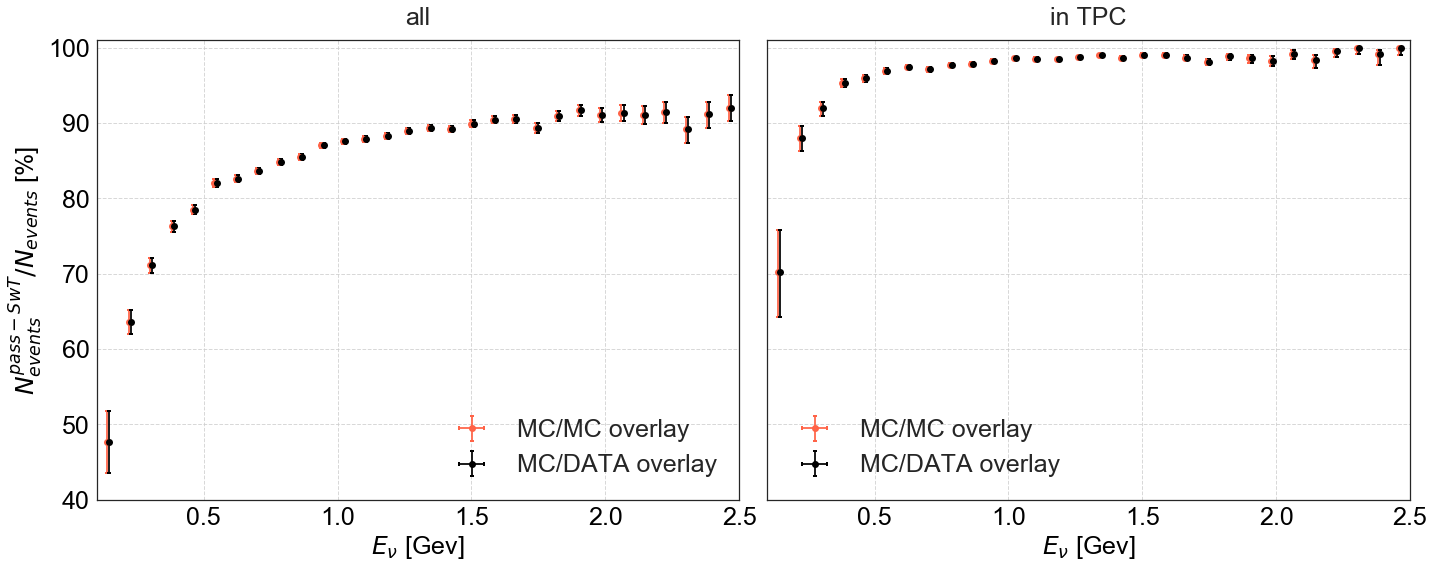

In [66]:
fig = plt.figure(figsize=(20,8))
for idir,(direction,bins,label) in enumerate(zip(['E','E'],[np.linspace(0.1,2.5,31),np.linspace(0.1,2.5,31)]
                                                        ,['all','in TPC'])):
    x_label=r'$E_\nu$ [Gev]'

    ax = fig.add_subplot(1,2,idir+1)
    for isample,(sample,slabel,color) in enumerate(zip([MC_MC_Overlay,MC_DATA_Overlay]
                                       ,['MC/MC overlay','MC/DATA overlay']
                                       ,['tomato','black'])):
        evnts = sample[label]
        h_evnts,bins = np.histogram(evnts[direction+'(v-interaction)'],bins=bins);
        evnts_passed_SwT = evnts[evnts['passed_SwT']==True]
        h_passed_SwT,bins = np.histogram(evnts_passed_SwT[direction+'(v-interaction)'],bins=bins);
        mid = 0.5*(bins[1:]+bins[:-1])

        h['eff'],h['eff lower'],h['eff upper'] = 0.0*h_evnts,0.0*h_evnts,0.0*h_evnts    
        for i in range(len(h_evnts)):
            eff,eff_upper,eff_lower = get_FeldmanCousinsEfficieny( passing=int(h_passed_SwT[i])
                                                                  ,tot=np.max([int(h_evnts[i]),1]))
            h['eff'][i],h['eff lower'][i],h['eff upper'][i]=eff,eff_upper,eff_lower
        plt.errorbar(x=mid+isample*0.1*(bins[1]-bins[0]),xerr=0
                     ,y=100*h['eff'],yerr=[100*h['eff lower'],100*h['eff upper']]
                     ,fmt='o',capthick=2,capsize=2,color=color,ecolor=color,label=slabel)

    set_axes(ax,x_label
             ,y_label=r'$N_{events}^{pass-SwT}/N_{events}$ [%]' if idir==0 else ''
             ,remove_ticks_y=True if idir>0 else False
             ,title=label
             ,do_add_grid=True,do_add_legend=True,xlim=(np.min(bins),np.max(bins)),ylim=(40,101))

plt.tight_layout()

# open-cosmic MC vs. extunbiased

In [73]:
events = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/events/SwT_pass_OpenCosmic_events.csv')
MC_DATA_Overlay=dict({'all':events
                       })

for key in MC_DATA_Overlay.keys():
    sample = MC_DATA_Overlay[key]
    events_passed_SwT = sample[sample['passed_SwT']==True]
    eff , eff_lower , eff_upper = get_FeldmanCousinsEfficieny( passing=len(events_passed_SwT), tot=len(sample))
    print key
    print len(sample),'events,',len(events_passed_SwT),'passed SwT (%.1f'%(100*eff),'+ %.1f'%(100*(eff_upper) ),'- %.1f'%(100*(eff_lower) ),'%)'

all
10600 events, 467 passed SwT (4.4 + 0.2 - 0.2 %)


In [74]:
events = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/events/SwT_pass_ExtUnbiased_events.csv')
MC_DATA_Overlay=dict({'all':events
                       })

for key in MC_DATA_Overlay.keys():
    sample = MC_DATA_Overlay[key]
    events_passed_SwT = sample[sample['passed_SwT']==True]
    eff , eff_lower , eff_upper = get_FeldmanCousinsEfficieny( passing=len(events_passed_SwT), tot=len(sample))
    print key
    print len(sample),'events,',len(events_passed_SwT),'passed SwT (%.1f'%(100*eff),'+ %.1f'%(100*(eff_upper) ),'- %.1f'%(100*(eff_lower) ),'%)'

all
1339 events, 0 passed SwT (0.0 + 0.1 - -0.0 %)


In [ ]:
def MC_MC_vs_MC_DATA(label='all'
                     ,direction= 'z',bins=np.linspace(-150,1250,31)
                     ,x_label=r'$z$ [cm]',TPClim=(0,1037)):
    
    MC_MC_sample = MC_MC_Overlay[label]
    MC_MC_sample_passed_SwT = MC_MC_sample[MC_MC_sample['passed_SwT']==True]
    MC_DATA_sample = MC_DATA_Overlay[label]
    MC_DATA_sample_passed_SwT = MC_DATA_sample[MC_DATA_sample['passed_SwT']==True]

    h = dict()
    fig = plt.figure(figsize=(12,10))
    for sample,slabel,color in zip([MC_MC_Overlay,MC_DATA_Overlay]
                                   ,['MC/MC overlay','MC/DATA overlay']
                                   ,['royalblue','teal']):
        evnts = sample[label]
        evnts_passed_SwT = evnts[evnts['passed_SwT']==True]

        h[slabel],bins,_=np.histogram(sample[direction+'(v-interaction)'],bins=bins);
#         plt.plot([0,0],[0,0],linewidth=3,label=slabel,color=color)
#     set_axes(ax,'','counts',do_add_legend=True,remove_ticks_x=True
#              ,do_add_grid=True,xlim=(np.min(bins),np.max(bins)),legend_loc='lower center')
#     plt.plot([TPClim,TPClim],ax.get_ylim(),'--',color='black')

    ax = fig.add_subplot(1,1,1)
    mid = 0.5*(bins[1:]+bins[:-1])
    den = h[label]
    num = h['passed SwT']
    h_ratio = [100.*num[i]/den[i] if den[i]>0 else 0 for i in range(len(den))]
    h_ratio_err = h_ratio*np.sqrt([1./num[i]+1./den[i] if den[i]>0 and num[i]>0 else 0 for i in range(len(den))]) #np.sqrt(1./h['passed SwT']+1./h['all events'])
    plt.errorbar(x=mid,xerr=0,y=h_ratio,yerr=h_ratio_err,fmt='o',capthick=2,capsize=2,ecolor='red')

    set_axes(ax,x_label,r'$N_{events}^{pass-SwT}/N_{events}$ [%]',do_add_grid=True,xlim=(np.min(bins),np.max(bins)),ylim=(0,110))
    plt.plot([TPClim,TPClim],ax.get_ylim(),'--',color='black')

    plt.tight_layout()

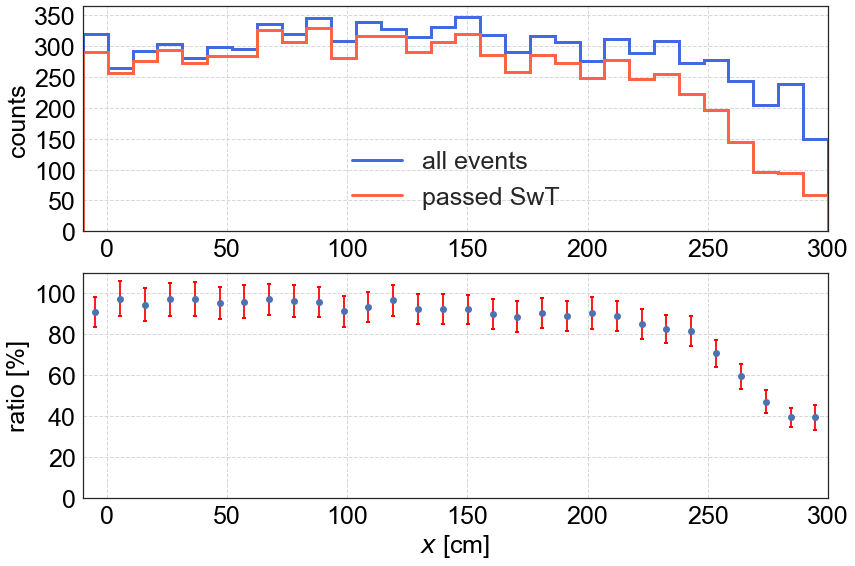

In [3]:
# direction,bins,x_label = 'E',np.linspace(-0.1,2,31),r'$E_\nu$ [GeV]'
direction,bins,x_label = 'x',np.linspace(-10,300,31),r'$x$ [cm]'
# direction,bins,x_label = 'y',np.linspace(-140,140,31),r'$y$ [cm]'
# direction,bins,x_label= 'z',np.linspace(-10,1100,31),r'$z$ [cm]'


h = dict()
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,1,1)
for sample,slabel,color in zip([events,events_passed_SwT]
                               ,['all events','passed SwT']
                               ,['royalblue','tomato']):
    h[slabel],bins,_=plt.hist(sample[direction+'(v-interaction)'],bins=bins,color=color,histtype='step',linewidth=3);
    plt.plot([0,0],[0,0],linewidth=3,label=slabel,color=color)
set_axes(ax,'','counts',do_add_legend=True,do_add_grid=True,xlim=(np.min(bins),np.max(bins)),legend_loc='lower center')
# ax.get_xaxis().set_major_formatter(NullFormatter())

ax = fig.add_subplot(2,1,2)
mid = 0.5*(bins[1:]+bins[:-1])
den = h['all events']
num = h['passed SwT']
h_ratio = [100.*num[i]/den[i] if den[i]>0 else 0 for i in range(len(den))]
h_ratio_err = h_ratio*np.sqrt([1./num[i]+1./den[i] if den[i]>0 and num[i]>0 else 0 for i in range(len(den))]) #np.sqrt(1./h['passed SwT']+1./h['all events'])
plt.errorbar(x=mid,xerr=0,y=h_ratio,yerr=h_ratio_err,fmt='o',capthick=2,capsize=2,ecolor='red')

set_axes(ax,x_label,'ratio [%]',do_add_grid=True,xlim=(np.min(bins),np.max(bins)),ylim=(0,110))


plt.tight_layout()

In [4]:
events_passed_SwT = events[events.passed_SwT==True]
events_in_TPC = events[(( (events['x(v-interaction)']>0)&(events['x(v-interaction)']<256)
                       &(events['y(v-interaction)']>-116)&(events['y(v-interaction)']<116)
                       &(events['z(v-interaction)']>0)&(events['z(v-interaction)']<1037))==True)]
events_in_TPC_passed_SwT = events_in_TPC[events_in_TPC.passed_SwT==True]

events_outside_TPC = events[(( (events['x(v-interaction)']>0)&(events['x(v-interaction)']<256)
                       &(events['y(v-interaction)']>-116)&(events['y(v-interaction)']<116)
                       &(events['z(v-interaction)']>0)&(events['z(v-interaction)']<1037))==False)]

events_outside_TPC_passed_SwT = events_outside_TPC[events_outside_TPC.passed_SwT==True]



ratio = float(len(events_passed_SwT))/len(events)
ratio_err = ratio*sqrt(1./len(events_passed_SwT)+1./len(events))
print len(events),'events,',len(events_passed_SwT),'passed SwT (%.1f'%(100*ratio),'+/- %.1f'%(100*ratio_err),'%)'
ratio = float(len(events_in_TPC_passed_SwT))/len(events_in_TPC)
ratio_err = ratio*sqrt(1./len(events_in_TPC_passed_SwT)+1./len(events_in_TPC))
print len(events_in_TPC),'events in TPC,',len(events_in_TPC_passed_SwT),'passed SwT (%.1f'%(100*ratio),'+/- %.1f'%(100*ratio_err),'%)'
ratio = float(len(events_outside_TPC_passed_SwT))/len(events_outside_TPC)
ratio_err = ratio*sqrt(1./len(events_outside_TPC_passed_SwT)+1./len(events_outside_TPC))
print len(events_outside_TPC),'events in TPC,',len(events_outside_TPC_passed_SwT),'passed SwT (%.1f'%(100*ratio),'+/- %.1f'%(100*ratio_err),'%)'

129300 events, 111510 passed SwT (86.2 +/- 0.4 %)
57227 events in TPC, 56027 passed SwT (97.9 +/- 0.6 %)
72073 events in TPC, 55483 passed SwT (77.0 +/- 0.4 %)


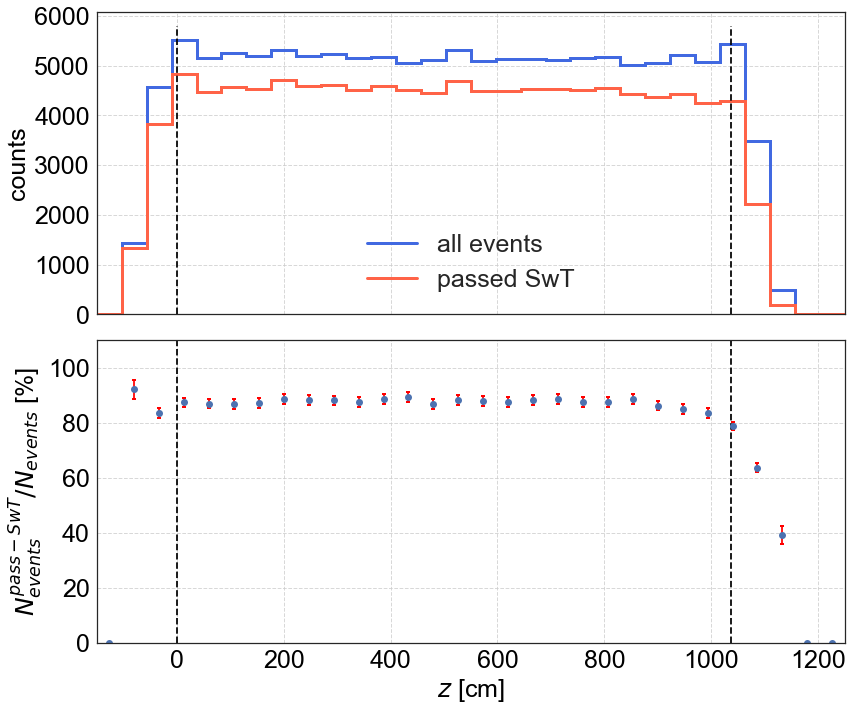

In [5]:
# direction,bins,x_label,TPClim = 'E',np.linspace(-0.1,2,31),r'$E_\nu$ [GeV]',(-0.1,2)
# direction,bins,x_label,TPClim = 'x',np.linspace(-80,330,31),r'$x$ [cm]',(0,256)
# direction,bins,x_label,TPClim = 'y',np.linspace(-201,201,31),r'$y$ [cm]',(-116,+116)
direction,bins,x_label,TPClim= 'z',np.linspace(-150,1250,31),r'$z$ [cm]',(0,1037)

events,events_passed_SwT

h = dict()
fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(2,1,1)
for sample,slabel,color in zip([events,events_passed_SwT]
                               ,['all events','passed SwT']
                               ,['royalblue','tomato']):
    h[slabel],bins,_=plt.hist(sample[direction+'(v-interaction)'],bins=bins,color=color,histtype='step',linewidth=3);
    plt.plot([0,0],[0,0],linewidth=3,label=slabel,color=color)
set_axes(ax,'','counts',do_add_legend=True,remove_ticks_x=True
#          ,title='prodgenie_bnb_nu_cosmic_uboone_mcc8.7_reco2_dev (6k events)'
         ,do_add_grid=True,xlim=(np.min(bins),np.max(bins)),legend_loc='lower center')
plt.plot([TPClim,TPClim],ax.get_ylim(),'--',color='black')

ax = fig.add_subplot(2,1,2)
mid = 0.5*(bins[1:]+bins[:-1])
den = h['all events']
num = h['passed SwT']
h_ratio = [100.*num[i]/den[i] if den[i]>0 else 0 for i in range(len(den))]
h_ratio_err = h_ratio*np.sqrt([1./num[i]+1./den[i] if den[i]>0 and num[i]>0 else 0 for i in range(len(den))]) #np.sqrt(1./h['passed SwT']+1./h['all events'])
plt.errorbar(x=mid,xerr=0,y=h_ratio,yerr=h_ratio_err,fmt='o',capthick=2,capsize=2,ecolor='red')

set_axes(ax,x_label,r'$N_{events}^{pass-SwT}/N_{events}$ [%]',do_add_grid=True,xlim=(np.min(bins),np.max(bins)),ylim=(0,110))
plt.plot([TPClim,TPClim],ax.get_ylim(),'--',color='black')



plt.tight_layout()